In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

/kaggle/input/full-filled-brain-stroke-dataset/full_data.csv
/kaggle/input/full-filled-brain-stroke-dataset/full_filled_stroke_data (1).csv


# Summary
I'm making a brain stroke prediction model using a neural network (NN). As the data is very biased towards the non-stroke persons (4733: 248), even the class weighting wasn't helped. So I used `RandomOverSampler` from `imblearn.over_sampling` to balance the dataset. After that I trained the model using varied learning rates to find a suitable value, then I trained the model again. The balancing and the chosen learning rate really improved the results. I might come back and try to improve the model again. I'm appreciate for any suggestions. Thank you.

# Data processing

In [2]:
df = pd.read_csv('../input/full-filled-brain-stroke-dataset/full_data.csv')
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


In [3]:
df.shape

(4981, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [5]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
df['stroke'].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

In [7]:
dataset = pd.get_dummies(df)
dataset.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0


In [8]:
X = dataset.copy()
y = X.pop('stroke')

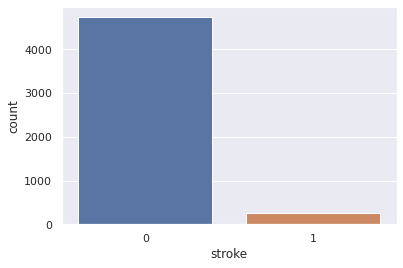

In [9]:
ax = sns.countplot(x=y)

## Balance the dataset
It can be seen that the classes are highly biased. I tried a class balancing but the performance on the smaller class was still bad (precision 0.14).

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

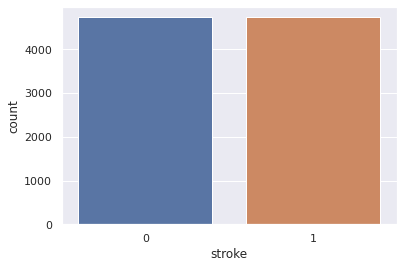

In [11]:
ax = sns.countplot(x=y)

## Train-/test dataset split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Normalize the X 
from sklearn.preprocessing import MinMaxScaler
obj_norm = MinMaxScaler().fit(X)
X_normalized = obj_norm.transform(X)
X_normalized[0]

array([0.81689453, 0.        , 1.        , 0.80126489, 0.64756447,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        ])

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(X_normalized, y, test_size = 0.3, random_state = 0)

In [15]:
train_features.shape, train_labels.shape

((6626, 19), (6626,))

In [16]:
test_features.shape, test_labels.shape

((2840, 19), (2840,))

# Regression with a deep neural network (DNN)

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

2.6.4
Found GPU at: /device:GPU:0


2022-08-28 14:23:21.759420: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-28 14:23:21.829200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 14:23:21.959790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 14:23:21.960780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [18]:
# Class weighting
print("[INFO] Class weighting...")
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(np.ravel(train_labels, order='C')),
                                                  y=np.ravel(train_labels, order='C'))

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

[INFO] Class weighting...
{0: 1.0024205748865356, 1: 0.9975910870219813}


In [19]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Actual is 0 and Prediction is 0: ', cm[0][0])
    print(f'Actual is 0 and Prediction is 1: ', cm[0][1])
    print(f'Actual is 1 and Prediction is 0: ', cm[1][0])
    print(f'Actual is 1 and Prediction is 1: ', cm[1][1])
    print(f'Total Correct Prediction: {np.sum(cm[0][0] + cm[1][1])} / {np.sum(cm)}')

## Callbacks on varied learning rate

In [20]:
model = Sequential([
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
  ])

2022-08-28 14:23:24.593038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 14:23:24.594064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 14:23:24.594796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 14:23:24.595759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 14:23:24.596480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [21]:
EPOCHS = 150
INIT_LR = 1e-1
lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optim_LR = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(optimizer=optim_LR, 
              loss=losses.binary_crossentropy, metrics=['accuracy'])

In [22]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=EPOCHS,
    verbose=0,
    validation_split = 0.2,
    callbacks=[lr_schedule],
    class_weight=class_weight_dict)

2022-08-28 14:23:25.130579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 1min 29s, sys: 10.6 s, total: 1min 40s
Wall time: 1min 22s


In [23]:
# plot the training results to see the loss against LR
lrs = 1e-8 * 10**(np.arange(EPOCHS)/20)

In [24]:
import plotly.express as px

fig = px.line(x=lrs, y=history.history["loss"], title='Learning rate vs loss', log_x=True)
fig.show()

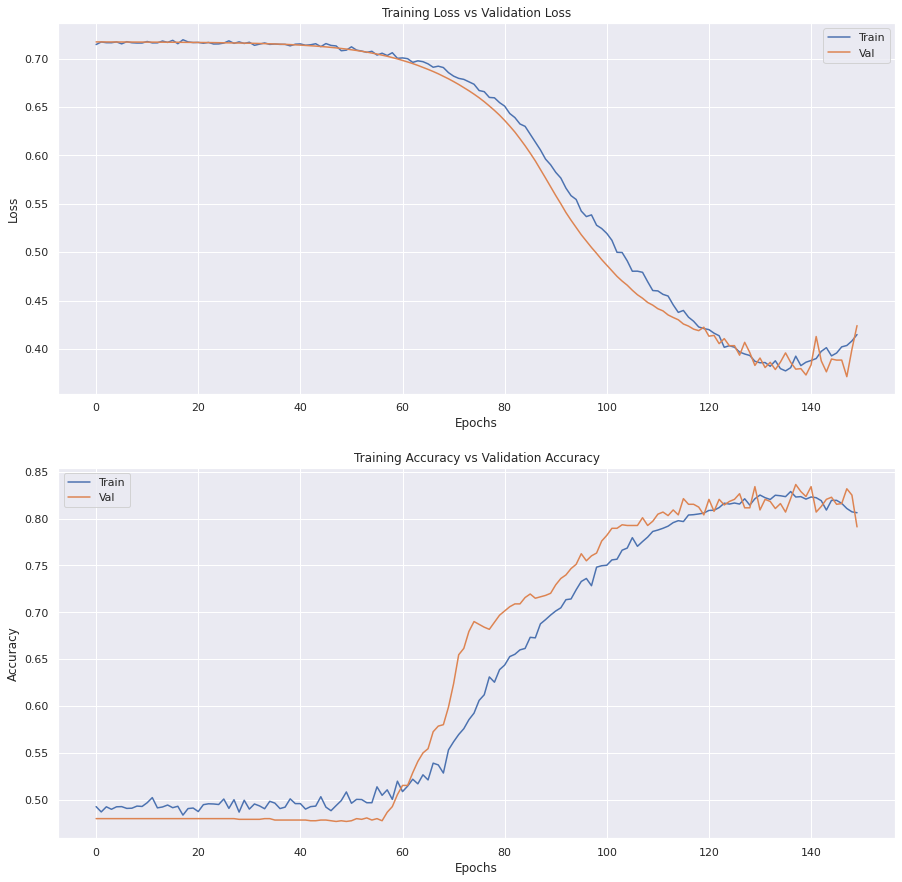

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

## Train again

In [26]:
model = Sequential([
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
  ])

In [27]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=20, mode='max', restore_best_weights=True)

LR = 1e-2
EPOCHS = 250
optim = Adam(learning_rate=LR, decay=LR / EPOCHS)

model.compile(optimizer=optim, 
              loss=losses.binary_crossentropy, metrics=['accuracy'])

In [28]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=EPOCHS,
    verbose=0,
    validation_split = 0.2,
    callbacks=[es],
    class_weight=class_weight_dict)

Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
CPU times: user 1min 14s, sys: 7.5 s, total: 1min 21s
Wall time: 56.9 s


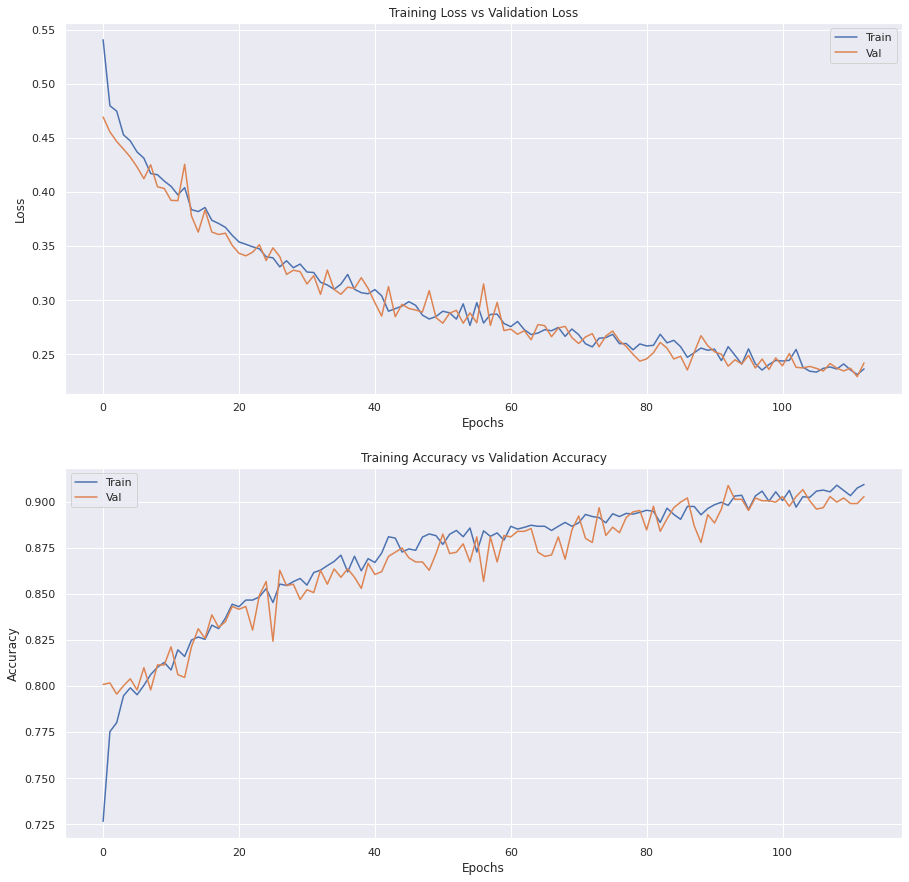

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [30]:
print("[INFO] Calculating model accuracy")
train_scores = model.evaluate(train_features, train_labels)
test_scores = model.evaluate(test_features, test_labels)
print(f"Test Accuracy (on train dataset): {train_scores[1]*100}")
print(f"Test Accuracy (on test dataset): {test_scores[1]*100}")

[INFO] Calculating model accuracy
89/89 [==============================] - 0s 2ms/step - loss: 0.2744 - accuracy: 0.9004
Test Accuracy (on train dataset): 92.65016317367554
Test Accuracy (on test dataset): 90.03521203994751


In [31]:
prediction = np.round(model.predict(test_features))
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      1428
           1       0.86      0.96      0.91      1412

    accuracy                           0.90      2840
   macro avg       0.91      0.90      0.90      2840
weighted avg       0.91      0.90      0.90      2840



Actual is 0 and Prediction is 0:  1201
Actual is 0 and Prediction is 1:  227
Actual is 1 and Prediction is 0:  56
Actual is 1 and Prediction is 1:  1356
Total Correct Prediction: 2557 / 2840


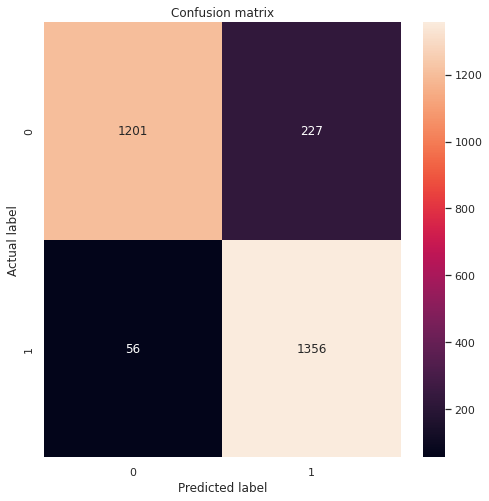

In [32]:
test_predictions_baseline = model.predict(test_features)
plot_cm(test_labels, test_predictions_baseline)
# 0 is 'not stroke', 1 is 'stroke'